In [57]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [51]:
df_desc = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name='descriptions')
df_factors = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name='factors').set_index('Date')
df_portfolios = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name='portfolios (total returns)').set_index('Date')

In [9]:
# 2
df_factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031


In [19]:
# 2.1
import pandas as pd

def calculate_univariate_performance_statistics(df, annualization_factor=1, quantile=0.05, periods=None):
    if periods is None:
        periods = [(df.index.min(), df.index.max())]
    
    summary_list = []

    for period in periods:
        start_date, end_date = period
        period_df = df.loc[start_date:end_date]
        
        summary_df = pd.DataFrame(index=period_df.columns)
        summary_df['Mean'] = period_df.mean() * annualization_factor
        summary_df['Volatility'] = period_df.std() * (annualization_factor ** 0.5)
        summary_df['Sharpe_ratio'] = summary_df['Mean'] / summary_df['Volatility']
        summary_df[f'VaR({quantile})'] = period_df.quantile(quantile, axis=0)
        
        start_year = pd.to_datetime(start_date).year
        end_year = pd.to_datetime(end_date).year
        summary_df['Period'] = f"{start_year}-{end_year}"
        
        summary_df = summary_df.reset_index().rename(columns={'index': 'Factor'}).set_index(['Period', 'Factor'])
        summary_list.append(summary_df)
    
    summary = pd.concat(summary_list)
    return summary



summary_statistics = calculate_univariate_performance_statistics(df_factors, 12)
# print(tabulate(summary_statistics, headers=summary_statistics.columns, tablefmt="heavy_grid"))
summary_statistics

Mean  Volatility  Sharpe_ratio  VaR(0.05)
Period    Factor                                               
1926-2024 Mkt-RF  0.082236     0.18471      0.445216  -0.079310
          SMB     0.021225     0.11004      0.192886  -0.042205
          HML     0.041237     0.12357      0.333713  -0.042100
          RF      0.032266     0.00867      3.721375   0.000000

In [20]:
periods = [(df_factors.index.min(), '1980-12-31'), ('1981-01-01', '2001-12-31'), ('2002-01-01', df_factors.index.max())]
summary_statistics = calculate_univariate_performance_statistics(df_factors, 12, periods=periods)
summary_statistics

Mean  Volatility  Sharpe_ratio  VaR(0.05)
Period    Factor                                               
1926-1980 Mkt-RF  0.081138    0.205050      0.395696  -0.083985
          SMB     0.033985    0.114568      0.296638  -0.043400
          HML     0.049479    0.133825      0.369727  -0.042910
          RF      0.027730    0.007671      3.614811   0.000000
1981-2001 Mkt-RF  0.077257    0.157396      0.490847  -0.064545
          SMB    -0.000862    0.118346     -0.007283  -0.046515
          HML     0.063776    0.111183      0.573612  -0.041790
          RF      0.063076    0.007753      8.135262   0.002455
2002-2024 Mkt-RF  0.089488    0.154644      0.578674  -0.078735
          SMB     0.011007    0.088944      0.123757  -0.039070
          HML     0.000538    0.107348      0.005014  -0.041245
          RF      0.014625    0.005029      2.908227   0.000000

#### 2.2
1. Does each factor have a premium (positive expected excess return) in each subsample?
The Market factor has a consistent positive premium across all periods.
This could indicate enduring market excess returns.
SMB (Size) and HML (Value) factors show mixed performance, with SMB even showing a slight negative premium in 1981-2001.
This could indicate no universal premium for these factors.

3. Does the premium to the size factor get smaller after 1980?
Yes, SMB's premium declines significantly after 1980 and even turns negative in the 1981-2001 period.
This could indicate reduced benefit from small-cap exposure post-1980.

4. Does the premium to the value factor get smaller during the 1990s?
HML's premium remains positive but less impactful in the 1990s, showing a marginal decline.
This could indicate reduced investor preference for value stocks during this time.

5. How have the factors performed since the time of the case (2002-present)?
Post-2002, Market factor shows a strong premium, but HML’s near-zero premium.
This could indicate minimal returns from value investing, reflecting shifting market dynamics.

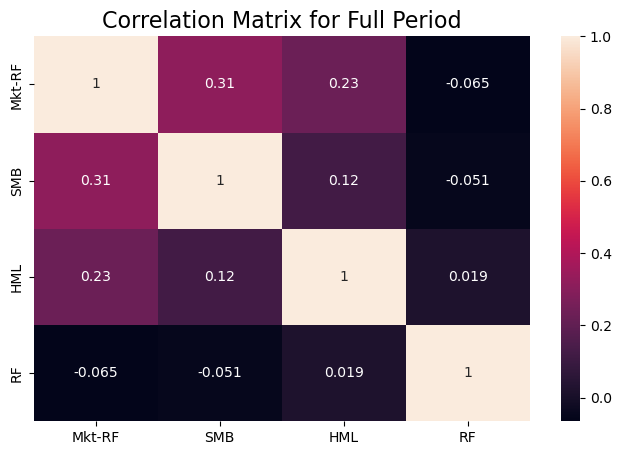

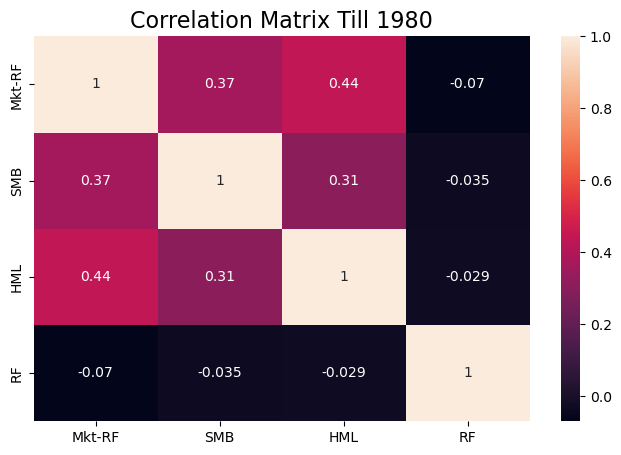

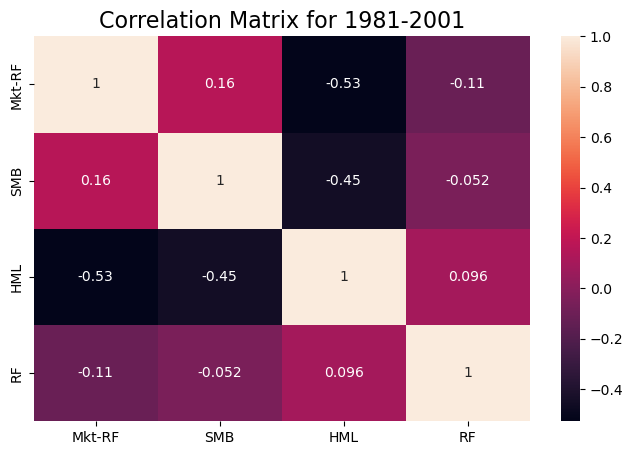

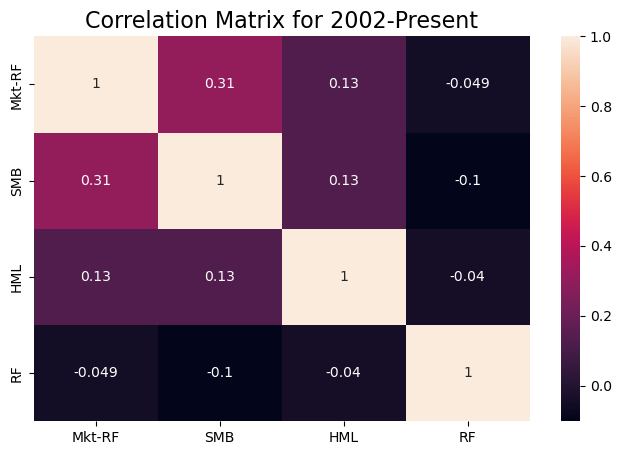

In [27]:
# 2.3
def plot_correlation_matrix(df, title=None, max_min=False):
    fig, ax = plt.subplots(figsize=(8, 5))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, 
                xticklabels=correlation_matrix.columns,
                yticklabels=correlation_matrix.columns, annot=True, ax=ax)
    if title:
        ax.set_title(title, fontsize=16)

    if max_min:
        corrs = correlation_matrix.unstack().sort_values().to_frame('Corr')
        corrs = corrs[corrs['Corr'] != 1]
        corrs_max = corrs.index[-1]
        corrs_min = corrs.index[0]
        print(f'Max Correlation pair is {corrs_max}')
        print(f'Min Correlation pair is {corrs_min}')

plot_correlation_matrix(df_factors, title="Correlation Matrix for Full Period")
plot_correlation_matrix(df_factors.loc[:'1980-12-31'], title="Correlation Matrix Till 1980")
plot_correlation_matrix(df_factors.loc['1981-01-01':'2001-12-31'], title="Correlation Matrix for 1981-2001")
plot_correlation_matrix(df_factors.loc['2002-01-01':], title="Correlation Matrix for 2002-Present")

1. The construction method effectively keeps correlations low, particularly evident in the negative or near-zero correlations between the Market (Mkt-RF), Size (SMB), and Value (HML) factors across all periods.
2. There are slight variations in correlation magnitudes across subsamples, the method generally succeeds in maintaining low correlations, supporting the robustness of factor independence over time.

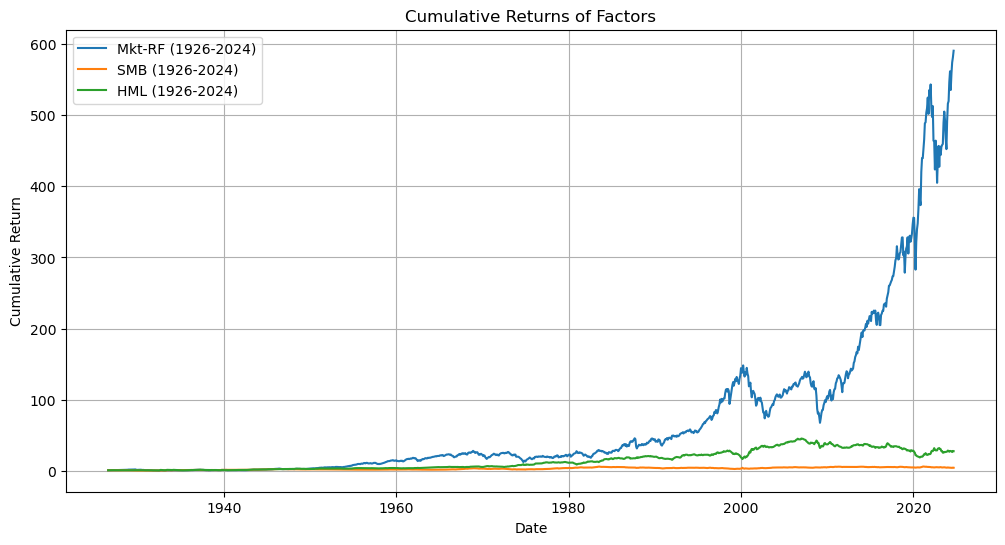

In [41]:
# 2.4
def plot_cumulative_returns(df, period=None, title="Cumulative Returns of Factors"):
    if period is None:
        period = (df.index.min(), df.index.max())
    
    start_date, end_date = pd.to_datetime(period[0]), pd.to_datetime(period[1])
    sub_df = df.loc[start_date:end_date]
    cumulative_returns = (1 + sub_df).cumprod()
    
    plt.figure(figsize=(12, 6))
    
    for column in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[column], label=f"{column} ({start_date.year}-{end_date.year})")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cumulative_returns(df_factors[['Mkt-RF', 'SMB', 'HML']])

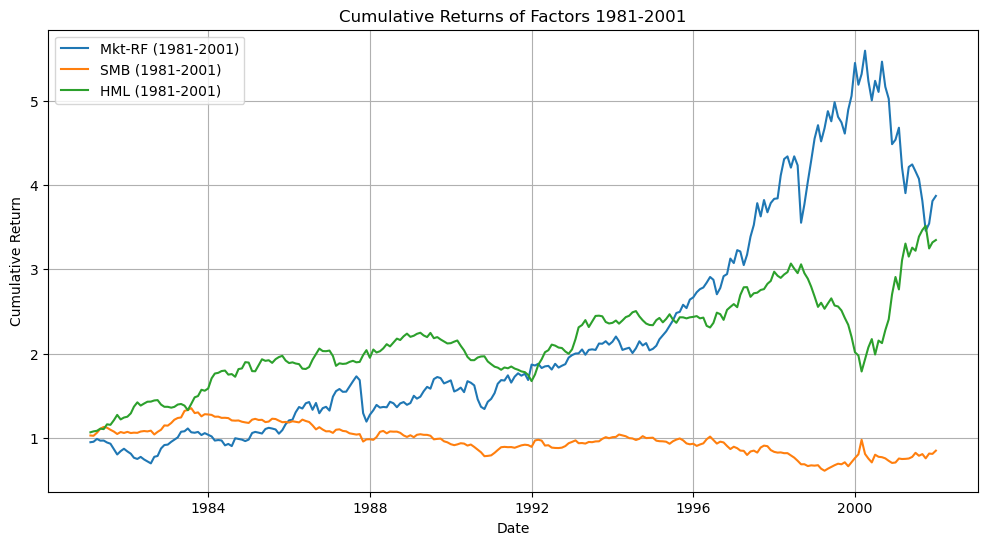

In [42]:
plot_cumulative_returns(
    df_factors[['Mkt-RF', 'SMB', 'HML']],
    title="Cumulative Returns of Factors 1981-2001",
    period=('1981-01-01','2001-12-31')
)

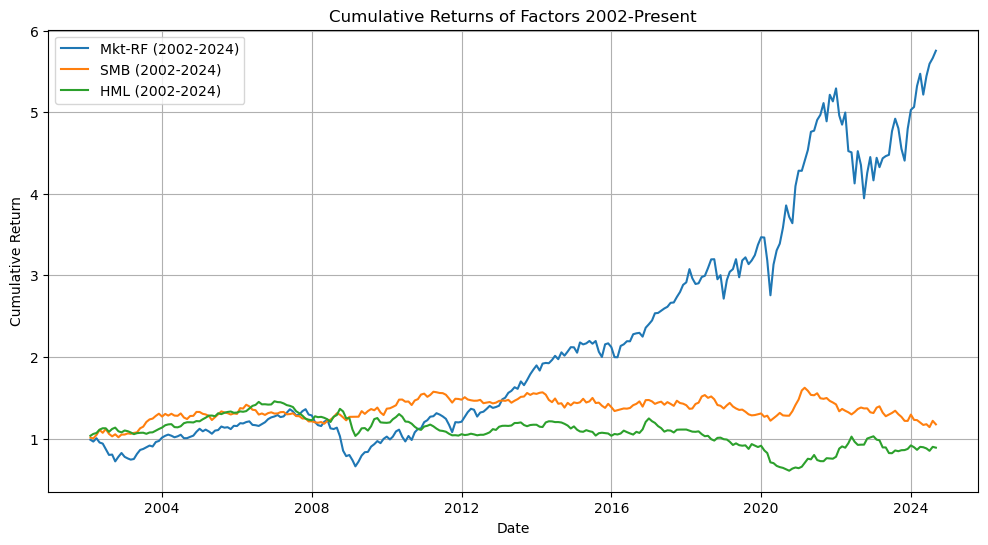

In [44]:
plot_cumulative_returns(
    df_factors[['Mkt-RF', 'SMB', 'HML']],
    title="Cumulative Returns of Factors 2002-Present",
    period=('2002-01-01', df_factors.index.max())
)

#### 2.5
1. The Market Risk Factor shines in both sub-samples but dips sharply with the tech bubble burst in 2001, allowing the Value Factor to post a premium amid depressed stock prices. The Size Factor, however, lags with near-zero or negative returns in 1981-2001.
2. Post-2002, the Market Factor recovers strongly, outpacing Size and Value, which post modest gains. Value sees declining premiums as stocks trade farther from fundamentals, though it still offers diversification.
3. Factor Rotation might be more effective going forward. The Size Factor seems outdated and correlated with the Market, while new factors like volatility, liquidity, and momentum could help DFA generate alpha in line with efficient market beliefs.

In [55]:
# 3
df_excess_portfolios = df_portfolios.sub(df_factors['RF'], axis=0)
df_excess_portfolios = df_excess_portfolios.loc['1980-01-01':]
df_excess_portfolios

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,0.120968,0.097081,0.077084,0.081934,0.102112,0.060874,0.066551,0.054849,0.038929,0.083738,...,0.067688,0.068742,0.056642,-0.000653,0.071922,0.025805,0.067176,0.048858,0.069689,0.094286
1980-02-29,-0.003334,-0.009988,-0.029950,-0.029022,-0.030309,-0.022365,-0.012437,-0.038256,-0.053325,-0.020158,...,-0.033645,-0.021075,-0.038852,-0.059094,-0.024141,-0.052290,0.001799,0.030872,0.008663,0.016002
1980-03-31,-0.232483,-0.206189,-0.187728,-0.168254,-0.188291,-0.203696,-0.177362,-0.179704,-0.158982,-0.188870,...,-0.134057,-0.153545,-0.142539,-0.121961,-0.179854,-0.075180,-0.126394,-0.107650,-0.125680,-0.140961
1980-04-30,0.049597,0.052449,0.055548,0.040424,0.048509,0.049915,0.035689,0.051613,0.065920,0.026693,...,0.034601,0.047512,0.061392,0.077948,0.054371,0.017377,0.021472,0.042008,0.065976,0.016031
1980-05-31,0.064197,0.057749,0.062203,0.058728,0.068799,0.082680,0.092047,0.060305,0.072658,0.090295,...,0.068477,0.072492,0.086546,0.063118,0.082155,0.041716,0.043952,0.044526,0.032097,0.053283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,-0.130128,-0.076561,-0.079804,-0.079124,-0.080168,-0.072984,-0.087440,-0.068110,-0.060808,-0.073370,...,-0.061889,-0.068962,-0.064723,-0.073261,-0.062037,-0.044696,0.007208,-0.049422,-0.054638,-0.059445
2024-05-31,0.067929,0.028121,0.044908,0.031166,0.043491,0.041575,0.027868,0.050656,0.044027,0.046318,...,0.021254,0.017390,0.019487,0.048526,0.031667,0.055412,0.037588,0.026122,0.036084,0.038259
2024-06-30,-0.047089,-0.027302,-0.060055,-0.020509,-0.029688,-0.023300,-0.024891,-0.024715,-0.019464,-0.032911,...,-0.010171,-0.021718,-0.026953,-0.020711,-0.031647,0.057072,0.006973,-0.000874,-0.020792,0.002003


In [56]:
# 3.1
portfolio_summary = calculate_univariate_performance_statistics(df_excess_portfolios)
portfolio_summary

Mean  Volatility  Sharpe_ratio  VaR(0.05)
Period    Factor                                                   
1980-2024 SMALL LoBM  0.001419    0.079786      0.017782  -0.127168
          ME1 BM2     0.007744    0.068673      0.112767  -0.095555
          ME1 BM3     0.007895    0.058512      0.134932  -0.086522
          ME1 BM4     0.009737    0.056332      0.172846  -0.077604
          SMALL HiBM  0.010739    0.060964      0.176154  -0.088662
          ME2 BM1     0.005500    0.071329      0.077103  -0.104243
          ME2 BM2     0.008766    0.059730      0.146759  -0.086073
          ME2 BM3     0.008899    0.054001      0.164794  -0.079012
          ME2 BM4     0.009169    0.052860      0.173462  -0.076861
          ME2 BM5     0.009707    0.062427      0.155490  -0.096663
          ME3 BM1     0.006377    0.065227      0.097769  -0.100920
          ME3 BM2     0.009106    0.054748      0.166330  -0.078919
          ME3 BM3     0.007814    0.050456      0.154868  -0.074080
          ME3 BM4     0.009073    0.052351      0.173319  -0.072261
          ME3 BM5     0.010163    0.059041      0.172130  -0.084564
          ME4 BM1     0.008152    0.058856      0.138502  -0.083935
          ME4 BM2     0.008368    0.051957      0.161055  -0.073752
          ME4 BM3     0.007854    0.050839      0.154494  -0.075668
          ME4 BM4     0.008271    0.050843      0.162685  -0.069787
          ME4 BM5     0.008919    0.057587      0.154886  -0.083540
          BIG LoBM    0.008021    0.047427      0.169124  -0.075375
          ME5 BM2     0.007406    0.045020      0.164508  -0.065725
          ME5 BM3     0.007226    0.044842      0.161133  -0.070663
          ME5 BM4     0.005919    0.049575      0.119398  -0.075962
          BIG HiBM    0.008240    0.059570      0.138324  -0.095337

1. The variation in mean excess returns across portfolios can partly be explained by their volatility, as higher returns often align with higher volatility levels, reflecting a risk-return tradeoff.
2. However, differences in VaR(0.05) statistics suggest that some portfolios face higher downside risk, indicating that volatility alone does not fully explain the variations in excess returns.

In [66]:
# 3.2
def capm_analysis(df_portfolios, df_market):

    alphas, betas, treynor_ratios, information_ratios, r_squared = [], [], [], [], []

    for col in df_portfolios.columns:
        y = df_portfolios[col]
        X = sm.add_constant(df_market)
        model = sm.OLS(y, X).fit()
        
        alpha = model.params['const']
        beta = model.params[df_market.name]
        
        mean_excess_return = y.mean()
        treynor_ratio = mean_excess_return / beta if beta != 0 else np.nan

        expected_return = alpha + beta * df_market.mean()
        residual_std_dev = model.resid.std()
        information_ratio = (mean_excess_return - expected_return) / residual_std_dev if residual_std_dev != 0 else np.nan

        alphas.append(alpha)
        betas.append(beta)
        treynor_ratios.append(treynor_ratio)
        information_ratios.append(information_ratio)
        r_squared.append(model.rsquared)

    results_df = pd.DataFrame({
        'Alpha': alphas,
        'Beta': betas,
        'Treynor Ratio': treynor_ratios,
        'Information Ratio': information_ratios,
        'R-Squared': r_squared
    }, index=df_portfolios.columns)
    
    return results_df

results_df = capm_analysis(df_excess_portfolios, df_factors['Mkt-RF'].loc['1980-01-01':])
results_df[['Alpha', 'Beta']]

,Alpha,Beta
SMALL LoBM,-0.008441,1.371406
ME1 BM2,-0.000691,1.173241
ME1 BM3,0.000337,1.051275
ME1 BM4,0.002743,0.972767
SMALL HiBM,0.003549,1.000091
ME2 BM1,-0.004180,1.346267
ME2 BM2,0.000580,1.138556
ME2 BM3,0.001486,1.031111
ME2 BM4,0.002144,0.977082
ME2 BM5,0.001702,1.113355


In [67]:
# 3.2b 
mae = np.mean(np.abs(results_df['Alpha']))
print("\nMean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.0017419341535378338


In [68]:
# 3.2c
results_df[['Beta', 'Treynor Ratio', 'Information Ratio']]

,Beta,Treynor Ratio,Information Ratio
SMALL LoBM,1.371406,0.001035,1.299129e-17
ME1 BM2,1.173241,0.006601,3.988112e-17
ME1 BM3,1.051275,0.007510,1.020286e-16
ME1 BM4,0.972767,0.010009,0.000000e+00
SMALL HiBM,1.000091,0.010738,8.503317e-17
ME2 BM1,1.346267,0.004085,4.687591e-17
ME2 BM2,1.138556,0.007699,1.151246e-16
ME2 BM3,1.031111,0.008631,0.000000e+00
ME2 BM4,0.977082,0.009384,1.200244e-16
ME2 BM5,1.113355,0.008718,4.714208e-17


#### 3.2d
1. Treynor Ratios should be similar across portfolios, as CAPM implies that returns are proportional to beta, suggesting a uniform return per unit of systematic risk.
2. Alphas should be close to zero for all portfolios, as CAPM assumes that all expected excess returns are captured by the market factor.
3. Information Ratios should be close to zero, indicating no significant deviations from the CAPM-predicted returns, meaning no additional risk-adjusted returns are being achieved beyond what CAPM explains.

In [72]:
# 3.3
capm_analysis(
    df_excess_portfolios.loc['1981-01-01':].mean().to_frame('Portfolio Mean Excess Returns'), 
    results_df['Beta']
)

,Alpha,Beta,Treynor Ratio,Information Ratio,R-Squared
Portfolio Mean Excess Returns,0.017365,-0.008984,-0.87062,-2.056712e-15,0.312132


1. R-Squared: 0.312132
2. Intercept: 0.017365
3. Regression Coefficient: -0.008984

1. R-Squared should be close to 1, as CAPM posits that beta should fully explain the cross-sectional variation in mean returns, implying a high explanatory power of the model.
2. Intercept should be close to zero, as CAPM suggests that all expected returns are captured by the relationship with beta, leaving no additional constant return.
3. Regression Coefficient should be Positive and equal to the market risk premium, reflecting the reward for taking on systematic risk. A negative coefficient, as seen here, would contradict CAPM, as it implies a penalty rather than a premium for beta exposure.

#### 3.4
1. Low R-squared, higher alphas, and CAPM’s limited beta suggest other risk factors, like size and value, play a key role in explaining portfolio returns.
2. Adding Size and Value factors boosts R-squared, aligning with DFA’s belief in the additional premia offered by these factors beyond CAPM.